## Research Ethics
This code makes use of the mitdeeplearning package (Amini, 2024) and trains a DB-VAE
inspired by the Debiasing Computer Vision Lab notebook from 6.S191.

### Copyright 2024 MIT 6.S191 Introduction to Deep Learning. All Rights Reserved. 
 
Licensed under the MIT License. You may not use this file except in compliance 
with the License. Use and/or modification of this code outside of 6.S191 must 
reference: 

© MIT 6.S191: Introduction to Deep Learning 
http://introtodeeplearning.com 

In [1]:
import os
CWD = os.getcwd()
print(CWD)
import h5py

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = "Times New Roman"

/mnt/e/ap_research


In [2]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import functools

2024-02-11 21:50:28.617703: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-11 21:50:28.617749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-11 21:50:28.618661: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-11 21:50:28.624843: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from tensorflow import keras
from keras import backend, layers, utils

In [4]:
import comet_ml
COMET_API_KEY = "t6Sqtes2FLSBv39Opo3q8TmVk"
from tqdm import tqdm
import mitdeeplearning as mdl

In [5]:
assert len(tf.config.list_physical_devices('GPU')) > 0
assert COMET_API_KEY != "", "Please insert your Comet API Key"
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

2024-02-11 21:50:30.443121: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-11 21:50:30.475685: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-11 21:50:30.475737: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.


In [6]:
### Create a Comet experiment to track our training run ###
def create_experiment(project_name, params):
    # end any prior experiments
    if 'experiment' in locals():
        experiment.end()

    # initiate the comet experiment for tracking
    experiment = comet_ml.Experiment(
    api_key=COMET_API_KEY,
    project_name=project_name)
    # log our hyperparameters, defined above, to the experiment
    for param, value in params.items():
        experiment.log_parameter(param, value)
    experiment.flush()

    return experiment


# Create our Standard ResNet50V2 CNN

In [28]:
def resize_images(x):
    return tf.image.resize(x, (64, 64))
def make_standard_ResNet50_V2(n_outputs = 1):
    
    Resize = tf.keras.layers.Lambda(resize_images)
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
    ResNet50V2 = tf.keras.applications.ResNet50V2(
        include_top=False,
        weights="imagenet", # Utilizing Transfer Learning, also maintains consistency
        input_tensor=None,
        input_shape=(64,64,3),
        pooling=None,
        classes=1000,
        classifier_activation="softmax",
    )
    ResNet50V2 = tf.keras.Model(inputs = ResNet50V2.layers[1].input, 
                                outputs = ResNet50V2.layers[-1].output)

    model = tf.keras.Sequential()
    
    model.add(Resize)
    model.add(ResNet50V2)
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dense(n_outputs, activation=None))

    return model

## ISIC Data Loading

In [22]:
### Examine Dataset ###
with h5py.File(f'{CWD}/datasets/ISIC/ISIC.h5','r') as f:
    # Print the keys (names) of all groups and datasets in the file
    print("Keys:", list(f.keys()))

    # Iterate through each key and print more detailed information
    for key in f.keys():
        if isinstance(f[key], h5py.Dataset):
            print(f"Dataset: {key}")
            print("  Shape:", f[key].shape)
            print("  Data type:", f[key].dtype)

Keys: ['images', 'labels']
Dataset: images
  Shape: (1976, 64, 64, 3)
  Data type: uint8
Dataset: labels
  Shape: (1976, 1)
  Data type: uint8


In [23]:
### Instantiate Loader Function ###
path_to_training_data= f'{CWD}/datasets/ISIC/ISIC.h5'
loader_ISIC = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

Opening /mnt/e/ap_research/datasets/ISIC/ISIC.h5
Loading data into memory...


1976


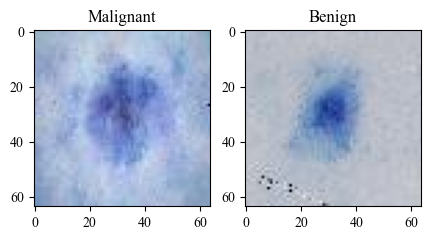

In [10]:
### Visualize our data ###
"""
Note that due to some sort of error while compression 
(presumably, the original JPEG files were in RGB channel, 
but the h5 file format compressed them as BGR)
our images appear blue.

However, since CNNs work on pixel values, this should not
have a massive effect on results.
"""
number_of_training_examples = loader_ISIC.get_train_size()
print(number_of_training_examples)
(images, labels) = loader_ISIC.get_batch(100)
malignant_images = images[np.where(labels==1)[0]]
benign_images = images[np.where(labels==0)[0]]

idx_malignant = 23
idx_benign = 9

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(malignant_images[idx_malignant])
plt.title("Malignant"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(benign_images[idx_benign])
plt.title("Benign"); plt.grid(False)

## ISIC_DiDI Data Loading

In [7]:
### Examine Dataset ###
with h5py.File(f'{CWD}/datasets/ISIC_DiDI/ISIC_DiDI.h5','r') as f:
    # Print the keys (names) of all groups and datasets in the file
    print("Keys:", list(f.keys()))

    # Iterate through each key and print more detailed information
    for key in f.keys():
        if isinstance(f[key], h5py.Dataset):
            print(f"Dataset: {key}")
            print("  Shape:", f[key].shape)
            print("  Data type:", f[key].dtype)

Keys: ['images', 'labels']
Dataset: images
  Shape: (2632, 64, 64, 3)
  Data type: uint8
Dataset: labels
  Shape: (2632, 1)
  Data type: uint8


In [8]:
### Instantiate Loader Function ###
path_to_training_data= f'{CWD}/datasets/ISIC_DiDI/ISIC_DiDI.h5'
loader_ISIC_DiDI = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

Opening /mnt/e/ap_research/datasets/ISIC_DiDI/ISIC_DiDI.h5
Loading data into memory...


2632


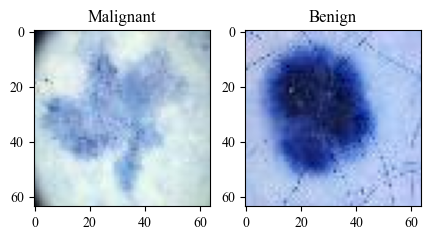

In [13]:
### Visualize our data ###
"""
Note that due to some sort of error while compression 
(presumably, the original JPEG files were in RGB channel, 
but the h5 file format compressed them as BGR)
our images appear blue.

However, since CNNs work on pixel values, this should not
have a massive effect on results.
"""
number_of_training_examples = loader_ISIC_DiDI.get_train_size()
print(number_of_training_examples)
(images, labels) = loader_ISIC_DiDI.get_batch(100)
malignant_images = images[np.where(labels==1)[0]]
benign_images = images[np.where(labels==0)[0]]

idx_malignant = 23
idx_benign = 9

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(malignant_images[idx_malignant])
plt.title("Malignant"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(benign_images[idx_benign])
plt.title("Benign"); plt.grid(False)

## ISIC_ArGI Data Loading

In [25]:
### Examine Dataset ###
with h5py.File(f'{CWD}/datasets/ISIC_ArGI/ISIC_ArGI.h5','r') as f:
    # Print the keys (names) of all groups and datasets in the file
    print("Keys:", list(f.keys()))

    # Iterate through each key and print more detailed information
    for key in f.keys():
        if isinstance(f[key], h5py.Dataset):
            print(f"Dataset: {key}")
            print("  Shape:", f[key].shape)
            print("  Data type:", f[key].dtype)

Keys: ['images', 'labels']
Dataset: images
  Shape: (2632, 64, 64, 3)
  Data type: uint8
Dataset: labels
  Shape: (2632, 1)
  Data type: uint8


In [26]:
### Instantiate Loader Function ###
path_to_training_data= f'{CWD}/datasets/ISIC_ArGI/ISIC_ArGI.h5'
loader_ISIC_ArGI = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

Opening /mnt/e/ap_research/datasets/ISIC_ArGI/ISIC_ArGI.h5
Loading data into memory...


# Model 1 - Standard ResNet50V2, trained on ISIC alone.

In [14]:
model_1 = make_standard_ResNet50_V2()

2024-02-11 21:14:53.938319: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-11 21:14:53.938404: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-11 21:14:53.938438: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-11 21:14:54.303973: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-11 21:14:54.304034: I external/local_xla/xla/stream_executor

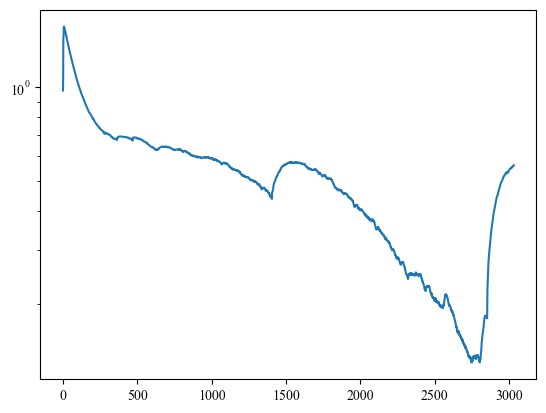

100%|██████████| 61/61 [00:05<00:00, 12.07it/s]


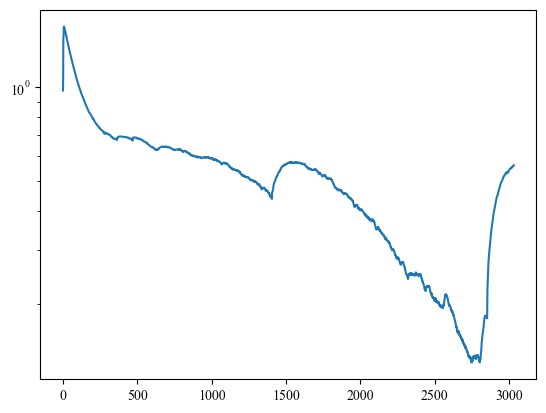

In [15]:
### Train the standard CNN ###

# Training hyperparameters
params = dict(
  batch_size = 32,
  num_epochs = 50,  # keep small to run faster
  learning_rate = 5e-4,
)

experiment = create_experiment("Model_1", params)

optimizer = tf.keras.optimizers.Adam(params["learning_rate"]) # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    # feed the images into the model
    logits = model_1(x)
    # Compute the loss
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
  grads = tape.gradient(loss, model_1.trainable_variables)
  optimizer.apply_gradients(zip(grads, model_1.trainable_variables))
  return loss

# The training loop!
step = 0
for epoch in range(params["num_epochs"]):
  for idx in tqdm(range(loader_ISIC.get_train_size()//params["batch_size"])):
    # Grab a batch of training data and propagate through the network
    x, y = loader_ISIC.get_batch(params["batch_size"])

    loss = standard_train_step(x, y)

    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

    experiment.log_metric("loss", loss.numpy().mean(), step=step)
    step += 1

In [16]:
steps = len(loss_history.get())
print(steps)

epochs = np.uint8(params['num_epochs'])
batches_per_epoch = np.uint8(steps/epochs)

loss_hist = np.zeros((steps,1))
for i in range(steps):
    loss_hist[i] = loss_history.get()[i]
loss_hist = loss_hist.reshape(epochs, batches_per_epoch)

row_means = np.zeros((epochs))
for i in range(epochs):
    row_means[i] = loss_hist.sum(axis=1)[i]

row_means = row_means/batches_per_epoch
for mean in row_means:
    print(mean)

3050
1.3792471580649102
1.0793789136886511
0.8871153992741116
0.779955616407629
0.7205735120599522
0.6904489093716111
0.6930188067039986
0.6861262269196144
0.6803275555318908
0.652860671907542
0.6361502652398893
0.6418746129989674
0.6308156611327463
0.6203744185307154
0.600714360808206
0.5948505037507313
0.5885412598064896
0.5721649685172455
0.5536190537490858
0.5311324384974418
0.5090108156932278
0.4872597246126077
0.46183644633373533
0.5055208294217209
0.5632504335323786
0.5724097379980595
0.5641997953654122
0.544092314836995
0.5246817667903055
0.5013094072920047
0.46557094739061927
0.4441112734267113
0.41059631228798565
0.384887454848412
0.3589367919107903
0.32869356713234243
0.2946089055633052
0.26512361968382187
0.2495993366006109
0.2400405549274471
0.21935661467709103
0.20083603007595716
0.20210738762448996
0.1668013575951833
0.1420952799480561
0.13419921093212042
0.19104367697164834
0.3929222742292074
0.5065979709162431
0.5522181811959106


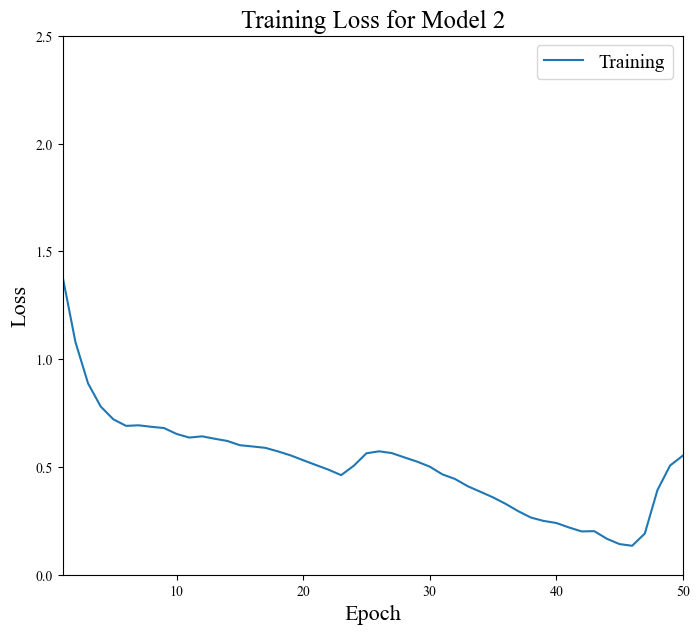

In [17]:
# Graph Loss
import matplotlib
matplotlib.rcParams['font.family'] = "Times New Roman"
epochs_range = np.arange(1,51)
plt.figure(figsize=(8,7))
size_axis_titles = 16
size_title = 18
size_legend = 14
plt.xlabel("Epoch", fontsize=size_axis_titles)
plt.ylabel("Loss", fontsize = size_axis_titles)
plt.axis([1, 50, 0, 2.5])
plt.plot(epochs_range,row_means,label='Training')
plt.legend(loc='upper right', fontsize=size_legend)
plt.title(f'Training Loss for Model 2', fontsize=size_title)
plt.show()

In [18]:
### Evaluation of standard CNN on ISIC ###
n=30
accuracies = np.zeros((n,1))
for i in range(n):
    (batch_x, batch_y) = loader_ISIC.get_batch(256) # Matches batch size
    y_pred_standard = tf.round(tf.nn.sigmoid(model_1.predict(batch_x)))
    acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
    accuracies[i] = acc_standard.numpy()

print(accuracies.mean())
print(accuracies.std())

8/8 [==============================] - 0s 20ms/step
0.7145833333333333
0.030938113770567134


In [19]:
### Evaluation of standard CNN on ISIC_DiDI ###
n=30
accuracies = np.zeros((n,1))

for i in range(n):
    (batch_x, batch_y) = loader_ISIC_DiDI.get_batch(256) # Matches batch size
    y_pred_standard = tf.round(tf.nn.sigmoid(model_1.predict(batch_x)))
    acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
    accuracies[i] = acc_standard.numpy()

print(accuracies.mean())
print(accuracies.std())

8/8 [==============================] - 0s 16ms/step
0.6486979166666667
0.020594332208091187


In [20]:
### Clear Previous Session ###
tf.keras.backend.clear_session()
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/88mangos/model-1/e981128006a647de8101df02284abdbc
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [3050] : (0.009589889086782932, 36.64596176147461)
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 32
COMET INFO:     learning_rate : 0.0005
COMET INFO:     num_epochs    : 50
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     installed packages           : 1
COMET INFO:     note

# Model 2 - Standard ResNet50V2, trained on ISIC_DiDI.

In [21]:
model_2 = make_standard_ResNet50_V2()

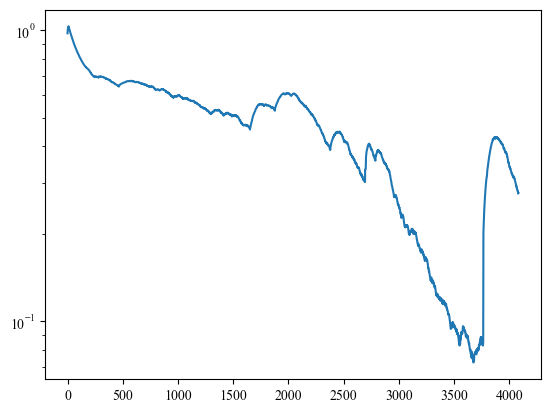

100%|██████████| 82/82 [00:06<00:00, 11.96it/s]


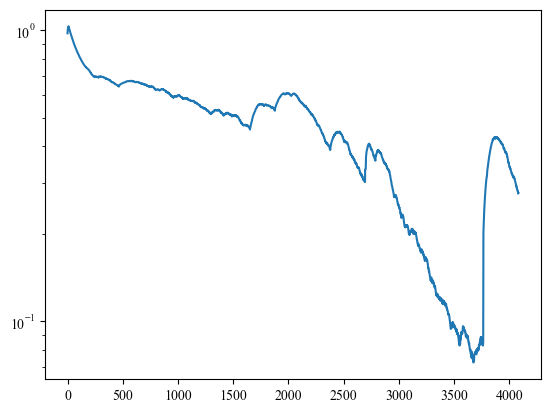

In [22]:
### Train the standard CNN ###

# Training hyperparameters
params = dict(
  batch_size = 32,
  num_epochs = 50,  # keep small to run faster
  learning_rate = 5e-4,
)

experiment = create_experiment("Model_2", params)

optimizer = tf.keras.optimizers.Adam(params["learning_rate"]) # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    # feed the images into the model
    logits = model_2(x)
    # Compute the loss
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
  grads = tape.gradient(loss, model_2.trainable_variables)
  optimizer.apply_gradients(zip(grads, model_2.trainable_variables))
  return loss

# The training loop!
step = 0
for epoch in range(params["num_epochs"]):
  for idx in tqdm(range(loader_ISIC_DiDI.get_train_size()//params["batch_size"])):
    # Grab a batch of training data and propagate through the network
    x, y = loader_ISIC_DiDI.get_batch(params["batch_size"])

    loss = standard_train_step(x, y)

    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

    experiment.log_metric("loss", loss.numpy().mean(), step=step)
    step += 1

In [23]:
steps = len(loss_history.get())
print(steps)

epochs = np.uint8(params['num_epochs'])
batches_per_epoch = np.uint8(steps/epochs)

loss_hist = np.zeros((steps,1))
for i in range(steps):
    loss_hist[i] = loss_history.get()[i]
loss_hist = loss_hist.reshape(epochs, batches_per_epoch)

row_means = np.zeros((epochs))
for i in range(epochs):
    row_means[i] = loss_hist.sum(axis=1)[i]

row_means = row_means/batches_per_epoch
for mean in row_means:
    print(mean)

4100
0.9439916791983219
0.7964911073948487
0.720191420500516
0.693198032219485
0.6771980450110083
0.6526634879764104
0.6658709769906743
0.6662149896221778
0.6518460478896825
0.6345778217394162
0.6238812177595544
0.5987300504924367
0.5913251254384249
0.5770323119672476
0.5547885232961972
0.5289153185695354
0.5293871356812887
0.5168027708376284
0.5075701096795595
0.4759818184868819
0.5046593782823312
0.5555995433964644
0.5453465620894694
0.5877063222479217
0.6046160645599388
0.5836606608557238
0.5370811254151225
0.4843186023717833
0.4195581556544693
0.4321119509615847
0.4252468176457649
0.36738095708442187
0.32435399442008955
0.38772717867250317
0.37365004340355135
0.3220339651917101
0.25321145626619856
0.21159468163154987
0.1938867015372199
0.16421750407813282
0.13187469829725282
0.11603729279552086
0.09829779391309842
0.09035992530969403
0.08085224310070803
0.09355986353766925
0.34804953107033326
0.4219900472851333
0.36960861111369925
0.2960395154513758


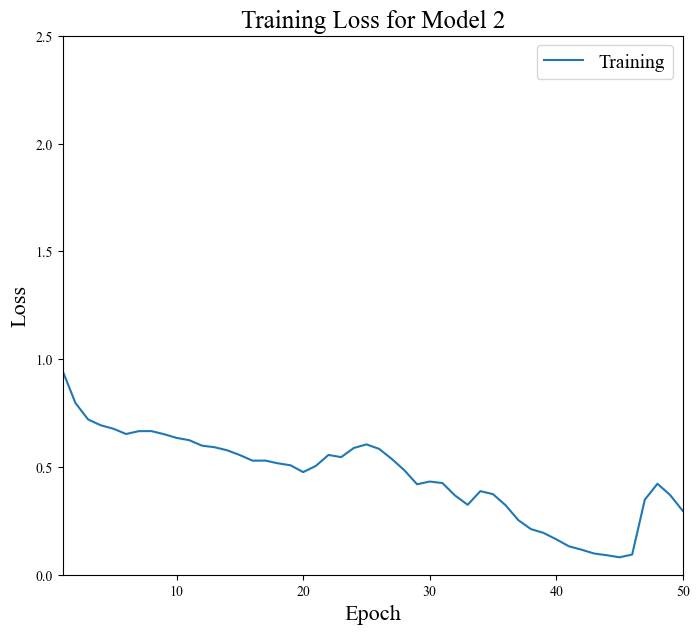

In [24]:
import matplotlib
matplotlib.rcParams['font.family'] = "Times New Roman"
epochs_range = np.arange(1,51)
plt.figure(figsize=(8,7))
size_axis_titles = 16
size_title = 18
size_legend = 14
plt.xlabel("Epoch", fontsize=size_axis_titles)
plt.ylabel("Loss", fontsize = size_axis_titles)
plt.axis([1, 50, 0, 2.5])
plt.plot(epochs_range,row_means,label='Training')
plt.legend(loc='upper right', fontsize=size_legend)
plt.title(f'Training Loss for Model 2', fontsize=size_title)
plt.show()

In [25]:
### Evaluation of standard CNN on ISIC ###
n=30
accuracies = np.zeros((n,1))

for i in range(n):
    (batch_x, batch_y) = loader_ISIC.get_batch(256) # Matches batch size
    y_pred_standard = tf.round(tf.nn.sigmoid(model_2.predict(batch_x)))
    acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
    accuracies[i] = acc_standard.numpy()

print(accuracies.mean())
print(accuracies.std())

8/8 [==============================] - 0s 15ms/step
0.9453125
0.011094483543823329


In [26]:
### Evaluation of standard CNN on ISIC_DiDI ###
n=30
accuracies = np.zeros((n,1))

for i in range(n):
    (batch_x, batch_y) = loader_ISIC_DiDI.get_batch(256) # Matches batch size
    y_pred_standard = tf.round(tf.nn.sigmoid(model_2.predict(batch_x)))
    acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
    accuracies[i] = acc_standard.numpy()

print(accuracies.mean())
print(accuracies.std())

8/8 [==============================] - 0s 19ms/step
0.945703125
0.013317582045418691


In [27]:
### Clear Previous Session ###
tf.keras.backend.clear_session()
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/88mangos/model-2/62b2e19c600343e4b3b7b4a826f048c1
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [4100] : (0.0012946233619004488, 11.478198051452637)
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 32
COMET INFO:     learning_rate : 0.0005
COMET INFO:     num_epochs    : 50
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     installed packages           : 1
COMET INFO:     no

# Model 3

In [29]:
model_3 = make_standard_ResNet50_V2()

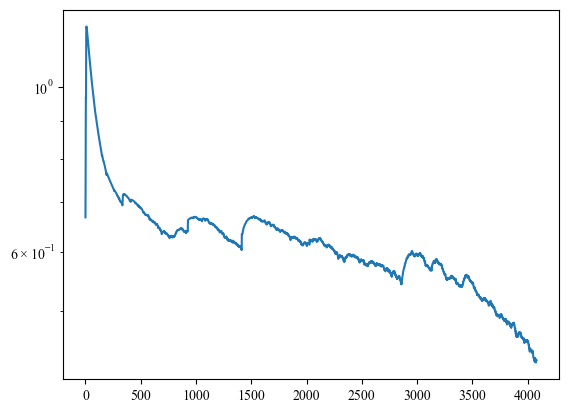

100%|██████████| 82/82 [00:06<00:00, 11.80it/s]


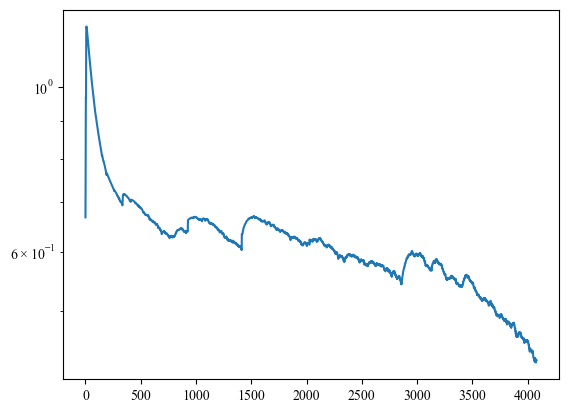

In [30]:
### Train the standard CNN ###

# Training hyperparameters
params = dict(
  batch_size = 32,
  num_epochs = 50,  # keep small to run faster
  learning_rate = 5e-4,
)

experiment = create_experiment("Model_3", params)

optimizer = tf.keras.optimizers.Adam(params["learning_rate"]) # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    # feed the images into the model
    logits = model_3(x)
    # Compute the loss
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
  grads = tape.gradient(loss, model_3.trainable_variables)
  optimizer.apply_gradients(zip(grads, model_3.trainable_variables))
  return loss

# The training loop!
step = 0
for epoch in range(params["num_epochs"]):
  for idx in tqdm(range(loader_ISIC_ArGI.get_train_size()//params["batch_size"])):
    # Grab a batch of training data and propagate through the network
    x, y = loader_ISIC_ArGI.get_batch(params["batch_size"])

    loss = standard_train_step(x, y)

    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

    experiment.log_metric("loss", loss.numpy().mean(), step=step)
    step += 1

In [31]:
steps = len(loss_history.get())
print(steps)

epochs = np.uint8(params['num_epochs'])
batches_per_epoch = np.uint8(steps/epochs)

loss_hist = np.zeros((steps,1))
for i in range(steps):
    loss_hist[i] = loss_history.get()[i]
loss_hist = loss_hist.reshape(epochs, batches_per_epoch)

row_means = np.zeros((epochs))
for i in range(epochs):
    row_means[i] = loss_hist.sum(axis=1)[i]

row_means = row_means/batches_per_epoch
for mean in row_means:
    print(mean)

4100
1.0546926234531084
0.8582933517866738
0.7597857240484409
0.7152406051887406
0.7099193406154776
0.6983271466607145
0.6779488839428733
0.6587009848712632
0.6398172702401715
0.6305215967860467
0.6422146068459315
0.65796289117398
0.6649605320082757
0.6602670810619855
0.6458814654915347
0.628084828397056
0.6164931574657829
0.6413146407401433
0.6674639862755842
0.6608455630470353
0.6527539431383284
0.6413600882400956
0.6307569007139735
0.6216590515470951
0.6172527824956396
0.6229512217161174
0.6138391704786302
0.6007954135534129
0.590210572346023
0.5926150573659471
0.58283766576286
0.579473018464947
0.5752773710348698
0.5647462591757795
0.5548170404923835
0.5860026386397463
0.5957520766253647
0.580916607547193
0.5790052941392105
0.5651618885033501
0.552518399880767
0.5454757858405253
0.5479239335544075
0.5228117851161231
0.5129831772119388
0.4954602581972349
0.4830210452396681
0.47089966565908287
0.45596026491385433
0.43401711138980154


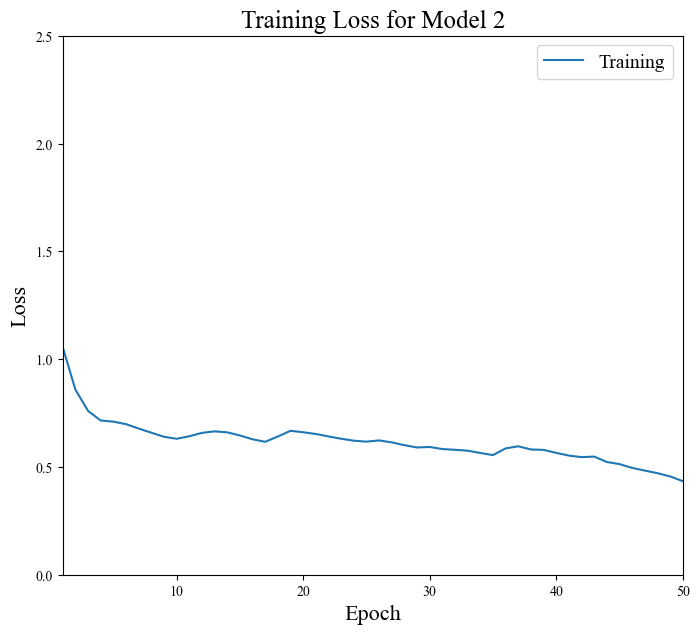

In [32]:
import matplotlib
matplotlib.rcParams['font.family'] = "Times New Roman"
epochs_range = np.arange(1,51)
plt.figure(figsize=(8,7))
size_axis_titles = 16
size_title = 18
size_legend = 14
plt.xlabel("Epoch", fontsize=size_axis_titles)
plt.ylabel("Loss", fontsize = size_axis_titles)
plt.axis([1, 50, 0, 2.5])
plt.plot(epochs_range,row_means,label='Training')
plt.legend(loc='upper right', fontsize=size_legend)
plt.title(f'Training Loss for Model 2', fontsize=size_title)
plt.show()

In [33]:
### Evaluation of standard CNN on ISIC ###
n=30
accuracies = np.zeros((n,1))

for i in range(n):
    (batch_x, batch_y) = loader_ISIC.get_batch(256) # Matches batch size
    y_pred_standard = tf.round(tf.nn.sigmoid(model_3.predict(batch_x)))
    acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
    accuracies[i] = acc_standard.numpy()

print(accuracies.mean())
print(accuracies.std())

8/8 [==============================] - 0s 17ms/step
0.838671875
0.020673622847498817


In [34]:
### Evaluation of standard CNN on ISIC_DiDI ###
n=30
accuracies = np.zeros((n,1))

for i in range(n):
    (batch_x, batch_y) = loader_ISIC_DiDI.get_batch(256) # Matches batch size
    y_pred_standard = tf.round(tf.nn.sigmoid(model_3.predict(batch_x)))
    acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
    accuracies[i] = acc_standard.numpy()

print(accuracies.mean())
print(accuracies.std())

8/8 [==============================] - 0s 16ms/step
0.7440104166666667
0.022726483572157737


# Model 4: Defining the DB-VAE Architecture

In [9]:
n_filters = 12 # base number of convolutional filters
latent_dim = 100 # number of latent variables
def make_decoder_network():
    """
    Layer Types, Functional Definition
    """
    Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
    Reshape = tf.keras.layers.Reshape

    decoder = tf.keras.Sequential([
        Dense(units=4*4*6*n_filters),  
        Reshape(target_shape=(4, 4, 6*n_filters)),

        # Upscaling convolutions (inverse of encoder)
        Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
        Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
        Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
        Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
    ])

    return decoder

In [10]:
### DB_VAE Helper Functions ###

### VAE Reparameterization ###
def sampling(z_mean, z_logsigma):
    batch, latent_dim = z_mean.shape
    epsilon = tf.random.normal(shape=(batch, latent_dim))
    z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
    return z

### Defining the VAE loss function ###
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  return vae_loss

### Loss function for DB-VAE ###
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
  malignance_indicator = tf.cast(tf.equal(y, 1), tf.float32)
  total_loss = tf.reduce_mean(
      classification_loss +
      malignance_indicator * vae_loss
  )
  return total_loss, classification_loss

In [11]:
### Define the CNN model ###

n_filters = 12 # base number of convolutional filters

'''Function to define a standard CNN model'''
def resize_images(x):
    return tf.image.resize(x, (64, 64))
def make_standard_classifier(n_outputs=1):
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  resize_layer = tf.keras.layers.Lambda(resize_images)
  model = tf.keras.Sequential()
  
  model.add(resize_layer)
  # https://www.reddit.com/r/learnmachinelearning/comments/zi3zqb/how_to_remove_layers_of_keras_functional_model/
  base_model = tf.keras.applications.ResNet50V2(
      include_top=False,
      weights="imagenet", # Utilizing Transfer Learning, also maintains consistency
      input_tensor=None,
      input_shape=(64,64,3),
      pooling=None,
      classes=1000,
      classifier_activation="softmax",
  )
  truncated_model = tf.keras.Model(inputs = base_model.layers[1].input, outputs = base_model.layers[-1].output)

  model.add(truncated_model)
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Dense(n_outputs, activation=None))

  return model

standard_classifier = make_standard_classifier()

2024-02-11 21:50:52.333085: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-11 21:50:52.333169: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-11 21:50:52.333202: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-11 21:50:52.576879: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-11 21:50:52.576972: I external/local_xla/xla/stream_executor

In [14]:
### Defining and creating the DB-VAE ###

class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DB_VAE, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder. Recall that we have
    # `latent_dim` latent variables, as well as a supervised output for the
    # classification.
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_classifier(num_encoder_dims)
    self.decoder = make_decoder_network()

  def encode(self, x):
    encoder_output = self.encoder(x)
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    z_mean = encoder_output[:, 1:self.latent_dim+1]
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  def reparameterize(self, z_mean, z_logsigma):
    z = sampling(z_mean, z_logsigma)
    return z

  def decode(self, z):
    reconstruction = self.decoder(z)
    return reconstruction

  def call(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    z = self.reparameterize(z_mean, z_logsigma)
    recon = self.decode(z)
    return y_logit, z_mean, z_logsigma, recon

  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

dbvae = DB_VAE(latent_dim)

In [15]:
dbvae = DB_VAE(latent_dim)

In [16]:
### DB_VAE Training Helper Functions ###

# Function to return the means for an input image batch
def get_latent_mu(images, dbvae, batch_size=1024):
    N = images.shape[0]
    mu = np.zeros((N, latent_dim))
    for start_ind in range(0, N, batch_size):
        end_ind = min(start_ind+batch_size, N+1)
        batch = (images[start_ind:end_ind]).astype(np.float32)/255.
        _, batch_mu, _ = dbvae.encode(batch)
        mu[start_ind:end_ind] = batch_mu
    return mu

def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001):
    print("Recomputing the sampling probabilities")
    mu = get_latent_mu(images, dbvae)
    training_sample_p = np.zeros(mu.shape[0])
    for i in range(latent_dim):
        latent_distribution = mu[:,i]
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')
        bin_idx = np.digitize(latent_distribution, bin_edges)
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)
        p = 1.0/(hist_smoothed_density[bin_idx-1])
        p = p / np.sum(p)
        training_sample_p = np.maximum(p, training_sample_p)
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

Starting epoch 50/50
Recomputing the sampling probabilities


  0%|          | 0/82 [00:00<?, ?it/s]

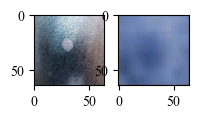

100%|██████████| 82/82 [00:06<00:00, 12.30it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/88mangos/model-4/d203012e8e2f48fabe61f3a5685658d0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [4100] : (0.056765228509902954, 4.541286468505859)
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 32
COMET INFO:     latent_dim    : 100
COMET INFO:     learning_rate : 0.0005
COMET INFO:     num_epochs    : 50
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename          

In [17]:
### Training the DB-VAE ###
import IPython
# Hyperparameters
params = dict(
  batch_size = 32,
  learning_rate = 5e-4,
  latent_dim = 100,
  num_epochs = 50, #DB-VAE needs slightly more epochs to train
)

experiment = create_experiment("Model_4", params)

# instantiate a new DB-VAE model and optimizer
dbvae = DB_VAE(params["latent_dim"])
optimizer = tf.keras.optimizers.Adam(params["learning_rate"])

@tf.function
def debiasing_train_step(x, y):

  with tf.GradientTape() as tape:
    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)
    loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)
  grads = tape.gradient(loss, dbvae.trainable_variables)
  optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
  return loss

all_imgs = loader_ISIC_DiDI.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

loss_history_2 = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
# The training loop -- outer loop iterates over the number of epochs
step = 0
for i in range(params["num_epochs"]):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, params["num_epochs"]))
  p_lesions = get_training_sample_probabilities(all_imgs, dbvae)

  for j in tqdm(range(loader_ISIC_DiDI.get_train_size() // params["batch_size"])):
    # load a batch of data
    (x, y) = loader_ISIC_DiDI.get_batch(params["batch_size"], p_pos=p_lesions)

    # loss optimization
    loss = debiasing_train_step(x, y)
    experiment.log_metric("loss", loss.numpy().mean(), step=step, epoch=i+1)
    loss_history_2.append(loss.numpy().mean())
    # plot the progress every 200 steps
    if j % 500 == 0:
      mdl.util.plot_sample(x, y, dbvae)

    step += 1

experiment.end()

In [18]:
steps = len(loss_history_2.get())
print(steps)

epochs = np.uint8(params['num_epochs'])
batches_per_epoch = np.uint8(steps/epochs)

loss_hist = np.zeros((steps,1))
for i in range(steps):
    loss_hist[i] = loss_history_2.get()[i]
loss_hist = loss_hist.reshape(epochs, batches_per_epoch)

row_means = np.zeros((epochs))
for i in range(epochs):
    row_means[i] = loss_hist.sum(axis=1)[i]

row_means = row_means/batches_per_epoch
for mean in row_means:
    print(mean)

4100
1.0774413308999509
0.9202618934090285
0.8001331447691342
0.7087511746391572
0.6482594783546064
0.6137185091072737
0.5819648053367821
0.5520821270216439
0.5060012638801146
0.4821553971161993
0.45098916952679324
0.4311418783922142
0.4125254893696508
0.3688838285018471
0.35216417476913053
0.33184597950345335
0.3301799488901858
0.31960933221333254
0.3025238327436955
0.28052508613796207
0.244098797670871
0.2317238761943207
0.21998140116545
0.2110045982313183
0.19792820758143417
0.19082836568804215
0.18006003373195892
0.17381748719292564
0.17951835383724632
0.16974308448829556
0.15975979699999937
0.14903344628453594
0.14219977757865485
0.153307274075905
0.14398673317056238
0.13217589606406602
0.12553688822971462
0.13125962721561085
0.13943153825547938
0.1358713780175433
0.13759436555609017
0.12902868560278405
0.1218306251224077
0.11093683539977661
0.11143976537229976
0.11214240205624064
0.11511213835488898
0.11349716356069639
0.11643227273790734
0.11869227648721825


In [24]:
### Evaluation of standard CNN on ISIC ###
n=30
accuracies = np.zeros((n,1))

for i in range(n):
    (batch_x, batch_y) = loader_ISIC.get_batch(256) # Matches batch size
    y_pred_standard = tf.round(tf.nn.sigmoid(dbvae.predict(batch_x)))
    acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
    accuracies[i] = acc_standard.numpy()

print(accuracies.mean())
print(accuracies.std())

0.9635416666666666
0.011646187382811403


In [20]:
### Evaluation of standard CNN on ISIC_DiDI ###
n=30
accuracies = np.zeros((n,1))

for i in range(n):
    (batch_x, batch_y) = loader_ISIC_DiDI.get_batch(256) # Matches batch size
    y_pred_standard = tf.round(tf.nn.sigmoid(dbvae.predict(batch_x)))
    acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
    accuracies[i] = acc_standard.numpy()

print(accuracies.mean())
print(accuracies.std())

0.9640625
0.010206207261596574
